Found 3001 images belonging to 8 classes.
Found 743 images belonging to 8 classes.


C:\Users\ghwns\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\ghwns\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.1814 - loss: 2.3953 - val_accuracy: 0.2450 - val_loss: 2.8247 - learning_rate: 1.0000e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.3837 - loss: 1.6480 - val_accuracy: 0.3244 - val_loss: 2.4325 - learning_rate: 1.0000e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.4150 - loss: 1.5182 - val_accuracy: 0.4065 - val_loss: 1.9298 - learning_rate: 1.0000e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.4650 - loss: 1.4097 - val_accuracy: 0.4024 - val_loss: 1.7728 - learning_rate: 1.0000e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.4831 - loss: 1.3664 - val_accuracy: 0.4630 - val_loss: 1.5633 - learning_rate: 1.0000e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.4995 - loss: 1.3344 - val_accuracy: 0.4441 - val_loss: 1.6864 - learning_rate: 1.0000e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.5453 

FileNotFoundError: [Errno 2] No such file or directory: './figures/exp_20250529_b2.png'

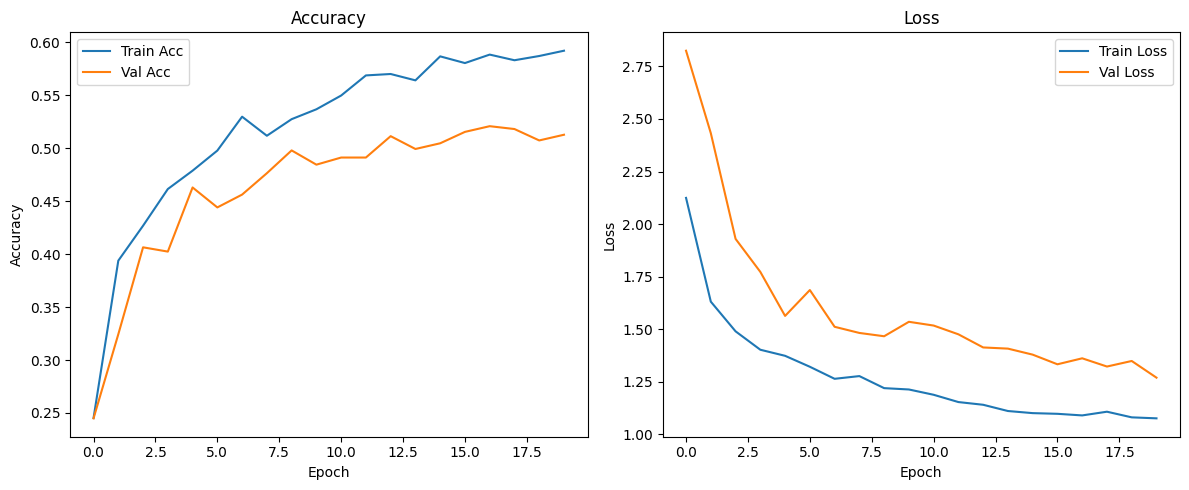

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 📂 Paths & Params
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
data_dir = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images"

# ✅ Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,  # 강화된 증강
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0
)

# ✅ Data Loader
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ✅ Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

# ✅ Model Setup (MobileNetV2 + Fine-tuning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ✅ Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stop],
    class_weight=class_weights
)

# ✅ Best Result
best_epoch = max(enumerate(history.history['val_accuracy']), key=lambda x: x[1])
print(f"\n🏆 Best Val Acc: {best_epoch[1]:.4f} at Epoch {best_epoch[0] + 1}")

# ✅ Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()